In [33]:
import os
import pandas as pd
import plotting
import numpy as np
import matplotlib.pyplot as plt 


In [34]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

data_features = pd.read_csv("data/features.csv")

ylabel_name = 'marions_ylabels'
ylabel_to_cluster_num = {'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data
labeled_num_features = plotting.extract_numerical_features(labeled_data)

In [35]:
import itertools
from sklearn.metrics import silhouette_score

combs = list(itertools.combinations(labeled_num_features.columns, 10))
min_silhouette_score = -1
min_features = None
for comb in combs:
    X = labeled_num_features[list(comb)].to_numpy()
    labels = labeled_data[f'{ylabel_name}_nums'].to_numpy()
    silhouette = silhouette_score(X, labels)
    # print(f"Silhouette Score: {silhouette:.2f}")
    if min_silhouette_score == -1 or silhouette < min_silhouette_score:
        min_silhouette_score = silhouette
        min_features = comb
print(f"Features with Minimum Silhouette Score: {min_features}")
print(f"Minimum Silhouette Score: {min_silhouette_score:.2f}")


Features with Minimum Silhouette Score: ('overall_slope', 'max_depth', 'max_resistance', 'largest_force_drop_res', 'first_quarter_slope', 'second_quarter_slope', 'third_quarter_slope', 'fourth_quarter_slope', 'quartile_3', 'kurtosis')
Minimum Silhouette Score: -0.37


# F-Score (Fisher Score)
Compares how much a feature varies between different classes versus how much it varies within the same class

                   Feature     Score
4       largest_force_drop  2.494812
13              quartile_2  2.136871
8      first_quarter_slope  2.098069
14              quartile_3  1.963651
12              quartile_1  1.910669
2           max_resistance  1.639763
1                max_depth  1.217037
0            overall_slope  1.085090
6   largest_force_drop_res  1.083226
3                num_peaks  0.997040
10     third_quarter_slope  0.885024
7              curve_shape  0.829074
5   largest_force_drop_dep  0.801167
9     second_quarter_slope  0.792380
15                    skew  0.679852
11    fourth_quarter_slope  0.610964
16                kurtosis  0.399125


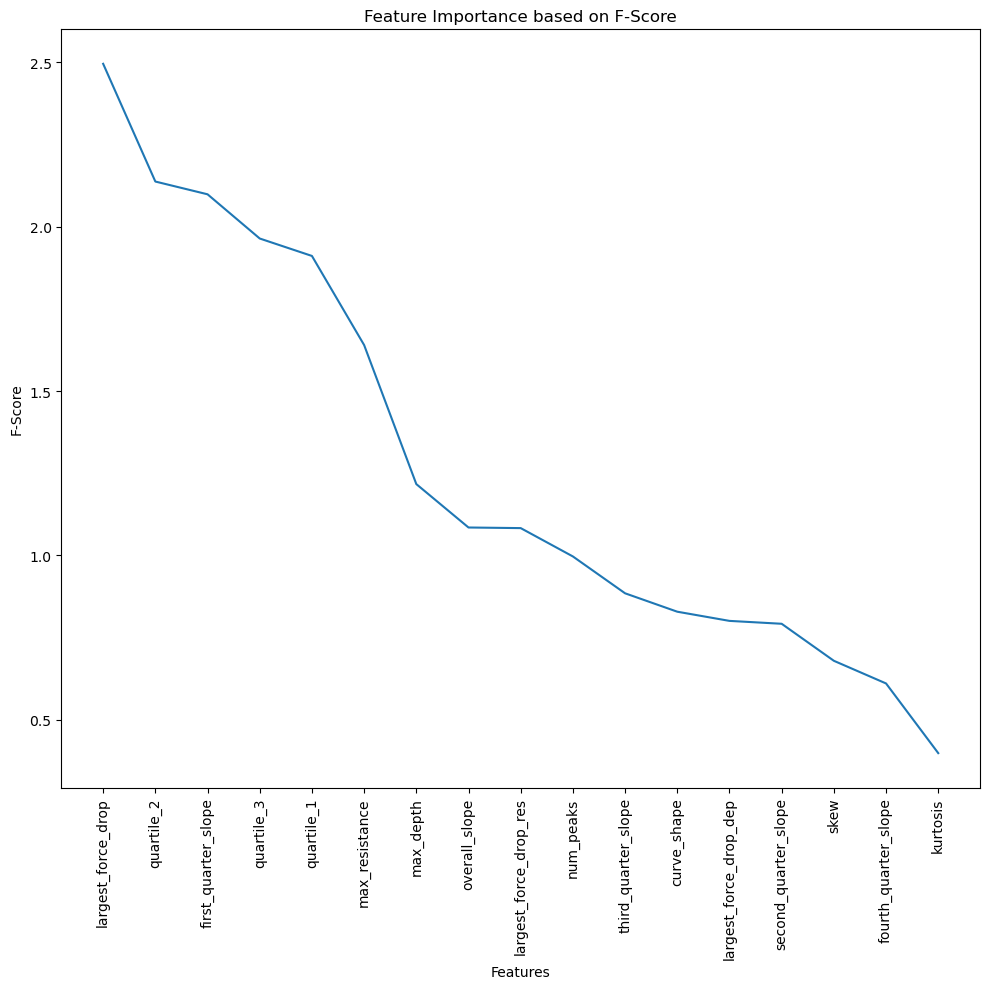

In [40]:
from sklearn.feature_selection import SelectKBest, f_classif

X = labeled_num_features.to_numpy()
y = labeled_data[f'{ylabel_name}_nums'].to_numpy()
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
scores = selector.scores_

# display results
feature_scores = pd.DataFrame({'Feature': labeled_num_features.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores) 

Fig = plt.figure(figsize=(10, 10))
plt.plot(feature_scores['Feature'], feature_scores['Score'])
plt.xlabel('Features')
plt.ylabel('F-Score')  
plt.title('Feature Importance based on F-Score')
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()